In [1]:
%matplotlib inline

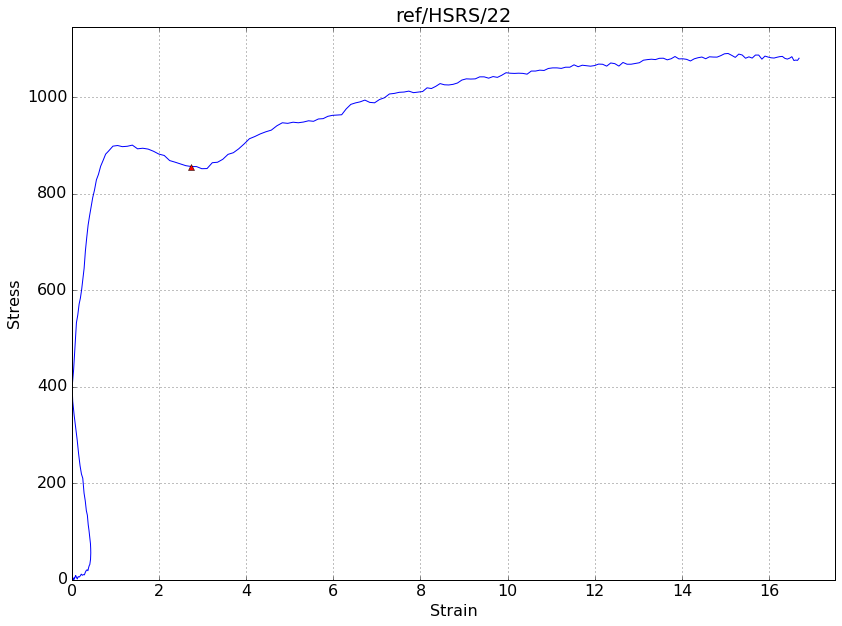

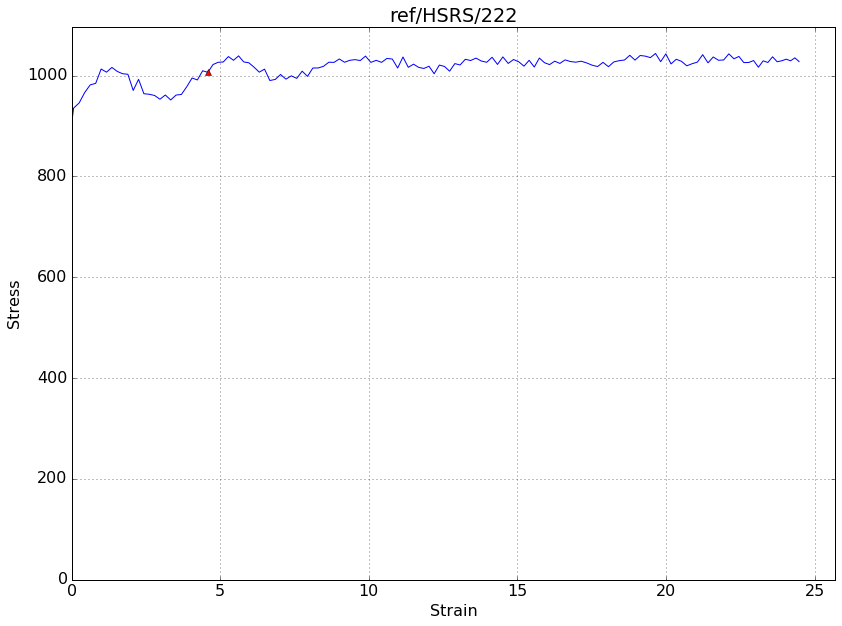

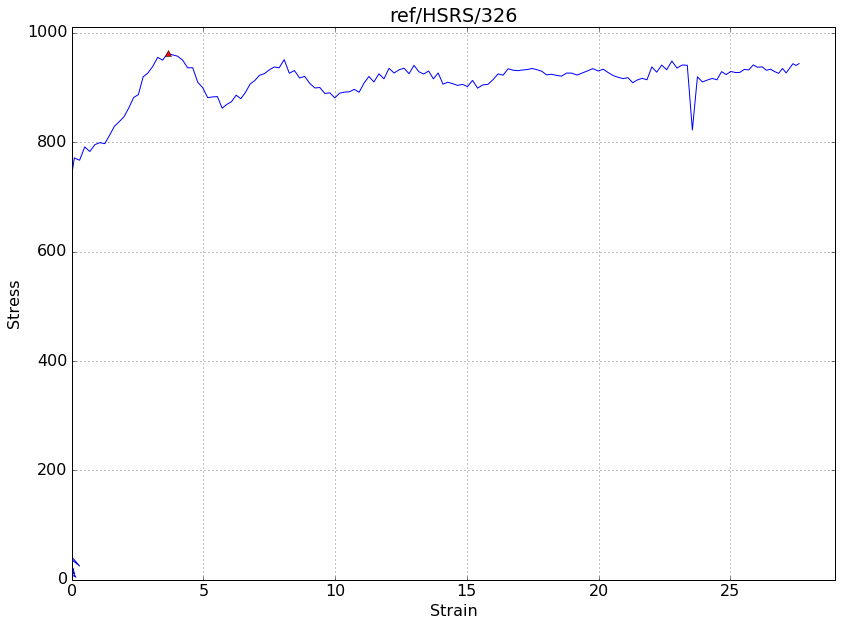

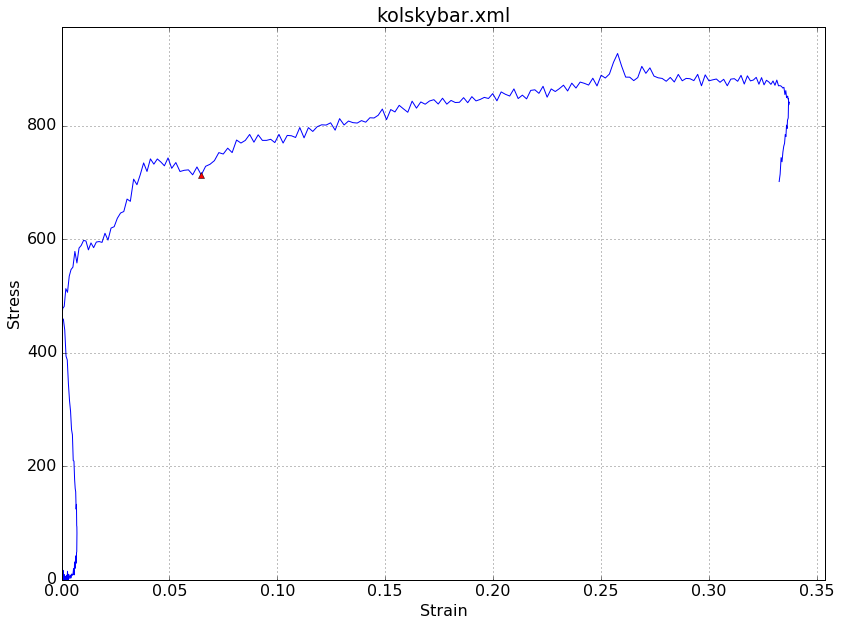

In [48]:
from irreversible_stressstrain import StressStrain as strainmodel
import test_suite as suite
import graph_suite as plot
import numpy as np
reload(suite)

xtitle = 'Strain'
ytitle = 'Stress'

name1 = 'ref/HSRS/22'
name2 = 'ref/HSRS/222'
name3 = 'ref/HSRS/326'
name4 = 'kolskybar.xml'

data1 = strainmodel(name1).get_experimental_data()
data2 = strainmodel(name2).get_experimental_data()
data3 = strainmodel(name3).get_experimental_data()
data4 = strainmodel(name4, type='xml').get_experimental_data()[:,:2]

yield1 = suite.yield_stress(data1)
yield2 = suite.yield_stress(data2)
yield3 = suite.yield_stress(data3,cutoff = 1) 
yield4 = suite.yield_stress(data4, decreasingend=True)

plot.plotmult2D(data1,yield1, title=name1, xtitle=xtitle, ytitle=ytitle)
plot.plotmult2D(data2,yield2, title=name2, xtitle=xtitle, ytitle=ytitle)
plot.plotmult2D(data3,yield3, title=name3, xtitle=xtitle, ytitle=ytitle)
plot.plotmult2D(data4,yield4, title=name4, xtitle=xtitle, ytitle=ytitle)

### The above is not promising, will try to create this locally, and then integrate to module

In [16]:
from irreversible_stressstrain import StressStrain as strainmodel
import test_suite as suite
import graph_suite as plot
import numpy as np
from scipy.optimize import curve_fit

# finds the yield stress of a dataset automatically
def yield_stress(model, numpoints=1000, cutoff=0.025, startx=None, endx=None):

    """Default interval values"""
    if startx is None:
        startx=min(model[:,0])+0.1

    if endx is None:
        endx=max(model[:,0])

    model = suite.delete_noise(model,cutoff=cutoff)
    model = suite.adjust(model)

    """a and c are parameters"""
    def fit(x, a,c):
        return a*np.log(x)+c

    strain = model[:,0]
    stress = model[:,1]

    optimal_params, cov_matrix = curve_fit(fit,strain,stress)

    a, c = optimal_params

    """The fitted version of the dataset"""
    def bestfit(x):
        return a*np.log(x)+c

    """We look for the place where the slope is average over the dataset"""
    gap_len = (endx-startx)/numpoints

    xs = np.linspace(startx,endx,numpoints)
    ys = bestfit(xs)

    pred_data = suite.combine_data(xs,ys)
    pred_slope = suite.get_slopes(pred_data)

    """Defining average slope by observing clusters in data"""
    #TODO COULD BE BECAUSE DATA4 IS THE REFERENCE HERE
    left, right = suite.kmeanssplit(data4)
    leftmid, rightmid = suite.midpoint(left)[None,:], suite.midpoint(right)[None,:]
    
    ave_slope = (rightmid[0,1]-leftmid[0,1])/(rightmid[0,0]-leftmid[0,0])

    
    """As soon as the slope at a point is less than the average slope, we stop"""
    for ind, slope in enumerate(pred_slope):

        if slope<ave_slope:
            break

    """
    We must take into account that we may not have a 
    data point in the experimental set where we have found a result
    """
    datapointind = ind*gap_len

    for ind, stra in enumerate(model[:,0]):

        if stra > datapointind:
            return model[ind][None,:]

    raise ValueError("The data does not seem to have a yield")
    
data1 = strainmodel('ref/HSRS/22').get_experimental_data()
data2 = strainmodel('ref/HSRS/222').get_experimental_data()
data3 = strainmodel('ref/HSRS/326').get_experimental_data()
data4 = strainmodel('kolskybar.xml',type='xml').get_experimental_data()[:,:2] # got rid of strain rate info
 
# cutoff depends on noise of data, 1 seems to work well for these measurements
yield1 = yield_stress(data1,cutoff=1.)
yield2 = yield_stress(data2)
yield3 = yield_stress(data3,cutoff=1.) 
yield4 = yield_stress(data4)

## This is the correct method to use! 1 for noisy data, the default value otherwise here, but other choices can be made

In [ ]:
from irreversible_stressstrain import StressStrain as strainmodel
import test_suite as suite
import graph_suite as plot
import numpy as np

# finds the yield stress of a dataset automatically
def yield_stress(model, numpoints=1000, cutoff=0.025, startx=None, endx=None):

    """Default interval values"""
    if startx is None:
        startx=min(model[:,0])+0.1

    if endx is None:
        endx=max(model[:,0])

    model = suite.delete_noise(model,cutoff=cutoff)
    model = suite.adjust(model)

    """a and c are parameters"""
    def fit(x, a,c):
        return a*np.log(x)+c

    strain = model[:,0]
    stress = model[:,1]

    optimal_params, cov_matrix = curve_fit(fit,strain,stress)

    a, c = optimal_params

    """The fitted version of the dataset"""
    def bestfit(x):
        return a*np.log(x)+c

    """We look for the place where the slope is average over the dataset"""
    gap_len = (endx-startx)/numpoints

    xs = np.linspace(startx,endx,numpoints)
    ys = bestfit(xs)

    pred_data = suite.combine_data(xs,ys)
    pred_slope = suite.get_slopes(pred_data)

    """Defining average slope by observing clusters in data"""
    #TODO THIS RUINS THE SPLIT, BECAUSE SPLITTING BY THESE CRITERIA DOESN'T REPRESENTATIVELY SPLIT
    left, right = suite.kmeanssplit(model)
    leftmid, rightmid = suite.midpoint(left)[None,:], suite.midpoint(right)[None,:]
    
    ave_slope = (rightmid[0,1]-leftmid[0,1])/(rightmid[0,0]-leftmid[0,0])

    
    """As soon as the slope at a point is less than the average slope, we stop"""
    for ind, slope in enumerate(pred_slope):

        if slope<ave_slope:
            break

    """
    We must take into account that we may not have a 
    data point in the experimental set where we have found a result
    """
    datapointind = ind*gap_len

    for ind, stra in enumerate(model[:,0]):

        if stra > datapointind:
            return model[ind][None,:]

    raise ValueError("The data does not seem to have a yield")
    
data1 = strainmodel('ref/HSRS/22').get_experimental_data()
data2 = strainmodel('ref/HSRS/222').get_experimental_data()
data3 = strainmodel('ref/HSRS/326').get_experimental_data()
data4 = strainmodel('kolskybar.xml',type='xml').get_experimental_data()[:,:2] # got rid of strain rate info
 
# cutoff depends on noise of data, 1 seems to work well for these measurements
yield1 = yield_stress(data1,cutoff=1.)
yield2 = yield_stress(data2)
yield3 = yield_stress(data3,cutoff=1.) 
yield4 = yield_stress(data4)


## Solving this midpoint issue, this one slope just happens to fit this material very well

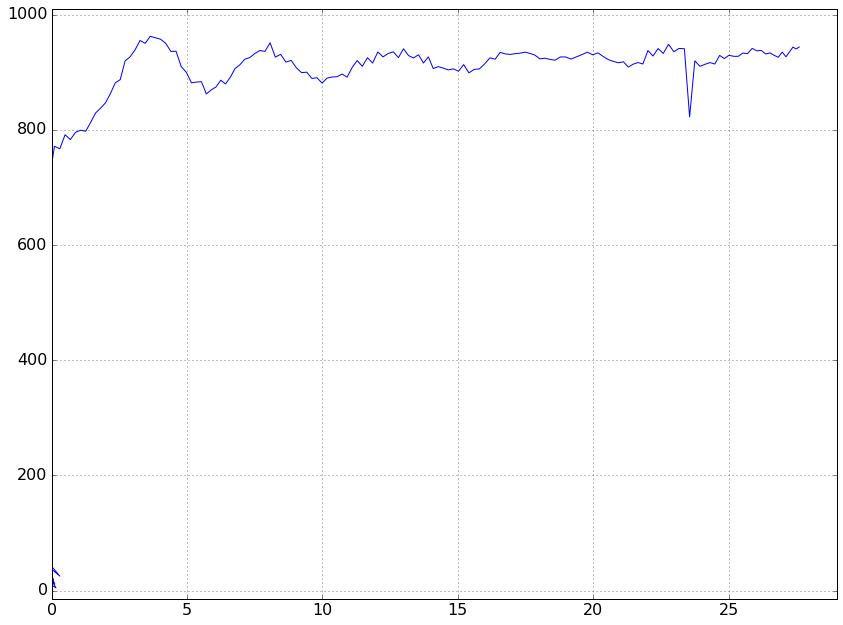

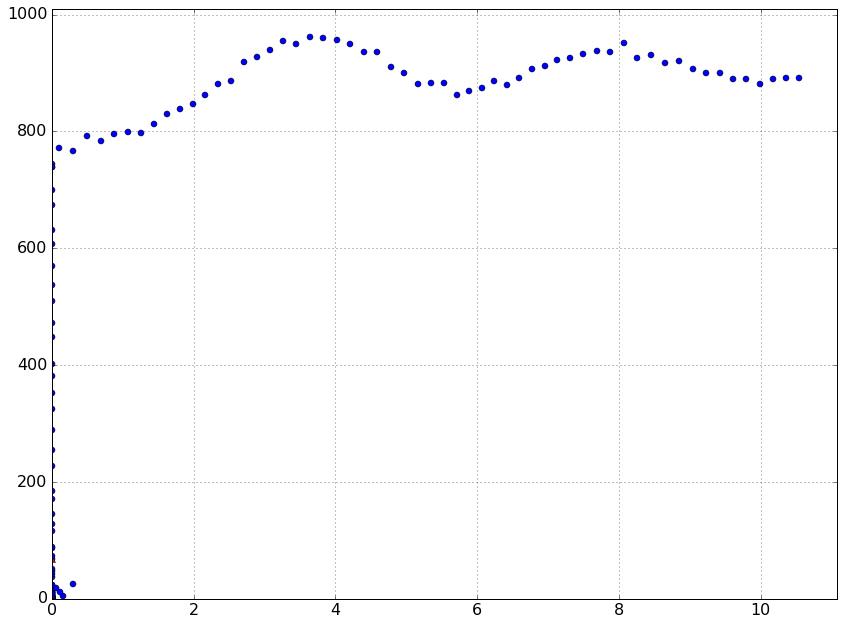

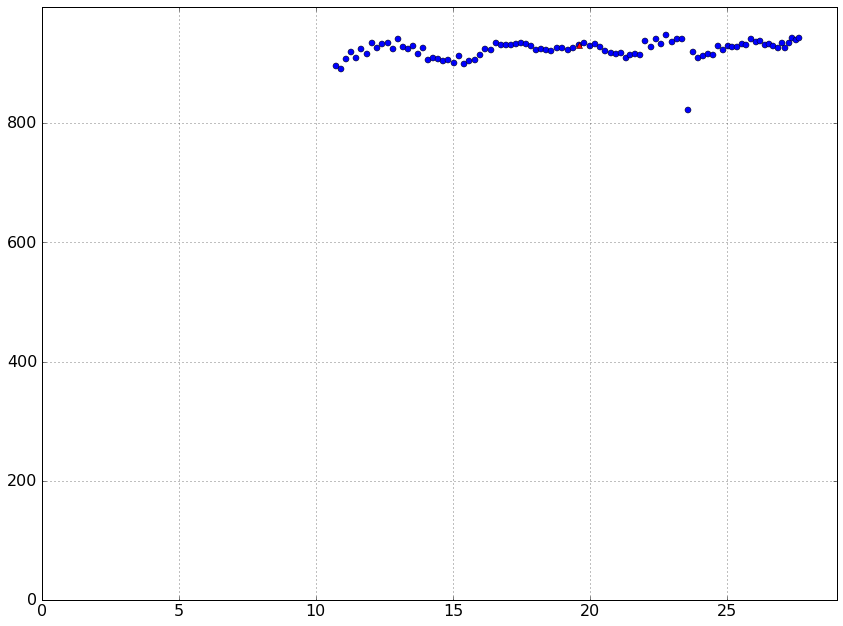

In [31]:
##CHECKING SAMPLE POINTS
reload(plot)
model = data3

left, right = suite.kmeanssplit(model)
leftmid, rightmid = suite.midpoint(left)[None,:], suite.midpoint(right)[None,:]

plot.plot2D(model)
plot.plotmult2D(left,leftmid,marker1='bo')
plot.plotmult2D(right,rightmid,marker1='bo')

## Fixed -- Currently going into bugfixing for XML parsing (not allowing a cutoff attribute)

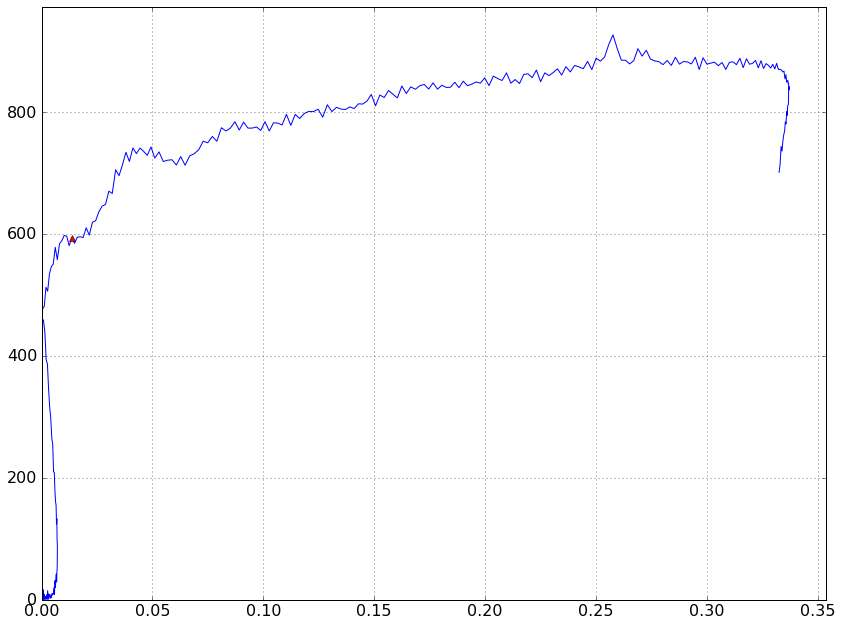

In [41]:
reload(suite)
xmldata = strainmodel('kolskybar.xml','xml').get_experimental_data()
plot.plotmult2D(xmldata,suite.yield_stress(xmldata,cutoff=0,decreasingend=True))